In [1]:
import models
import numpy as np
import os
import sys
import config_vmc as cv_module
from numba import jit
from scipy.linalg import schur
from copy import deepcopy
@jit(nopython=True)
def from_linearized_index(index, L, n_orbitals, n_sublattices = 2):
    orbit = index % n_orbitals
    coord = index // n_orbitals
    sublattice = coord % n_sublattices
    coord = coord // n_sublattices

    x = coord // L
    y = coord % L
    return orbit, sublattice, x, y


@jit(nopython=True)
def to_linearized_index(x, y, sublattice, orbit, L, n_orbitals, n_sublattices = 2):
    return orbit + n_orbitals * (sublattice + n_sublattices * (y + x * L))

@jit(nopython=True)
def nearest_neighbor_hexagonal(r1, r2, L):
    if r1[1] == r2[1] and r1[0] == r2[0]:
        return True, 1
    if r1[1] == r2[1] and diff_modulo(r1[0], r2[0], L, 1):
        return True, 2
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 3
    return False, 0

@jit(nopython=True)
def next_nearest_neighbor_hexagonal(r1, r2, L):
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 1

    if diff_modulo(r1[0], r2[0], L, 1) and r1[1] == r2[1]:
        return True, 2

    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, -1):
        return True, 4

    if diff_modulo(r1[0], r2[0], L, -1) and r1[1] == r2[1]:
        return True, 5

    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -1):
        return True, 3

    if diff_modulo(r1[0], r2[0], L, -1) and diff_modulo(r1[1], r2[1], L, 1):
        return True, 6

    return False, -1


@jit(nopython=True)
def fifth_nearest_neighbor(r1, r2, L):
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -2):
        return True
    if diff_modulo(r1[0], r2[0], L, -2) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    return False


@jit(nopython=True)
def diff_modulo(x, y, L, d):
    if d >= 0:
        return (x - y + L) % L == d  # or (x - y + L) % L == L - d
    return (x - y + L) % L == L + d

@jit(nopython=True)
def _model_hex_2orb_Koshino(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    t1, t2, t5, t4 = 0.331, (-0.010 * 0. + 1.0j * 0.097), 0 * 0.119, 0 * 0.036


    K = np.zeros((total_dof // 2, total_dof // 2)) * 1.0j
    for first in range(total_dof // 2):
        for second in range(total_dof // 2):
            orbit1, sublattice1, x1, y1 = from_linearized_index(first, Ls, n_orbitals, n_sublattices)
            orbit2, sublattice2, x2, y2 = from_linearized_index(second, Ls, n_orbitals, n_sublattices)

            r1 = np.array([x1, y1])
            r2 = np.array([x2, y2])

            if orbit1 == orbit2 and nearest_neighbor_hexagonal(r1, r2, Ls)[0] and sublattice1 == 0 and sublattice2 == 1:
                K[first, second] = t1

            if orbit2 == orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                K[first, second] = np.real(t2)
            if orbit2 != orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                if orbit1 == 0 and orbit2 == 1:
                    K[first, second] = np.imag(t2)
                else:
                    K[first, second] = -np.imag(t2)

    K = K + K.conj().T
    return K


def import_config(filename: str):
    import importlib

    module_name, extension = os.path.splitext(os.path.basename(filename))
    module_dir = os.path.dirname(filename)
    if extension != ".py":
        raise ValueError(
            "Could not import the module from {!r}: not a Python source file.".format(
                filename
            )
        )
    if not os.path.exists(filename):
        raise ValueError(
            "Could not import the module from {!r}: no such file or directory".format(
                filename
            )
        )
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_name)
    sys.path.pop(0)
    return module

@jit(nopython=True)
def get_fft(N, n_bands):
    W = np.zeros((N ** 2, N ** 2), dtype=np.complex128)
    for kx in range(N):
        for ky in range(N):
            for x in range(N):
                for y in range(N):
                    W[x * N + y, kx * N + ky] = np.exp(2.0j * np.pi / N * kx * x + 2.0j * np.pi / N * ky * y)
    return np.kron(W, np.eye(n_bands)) / N / np.sqrt(n_bands)
L = 6

@jit(nopython=True)
def fermi(energy, beta):
    return 1 / (1. + np.exp(energy * beta))

@jit(nopython=True)
def lattice_to_physical(lattice):
    x = (lattice[0] + lattice[1]) * np.sqrt(3) / 2
    y = (lattice[0] - lattice[1]) / 2

    if lattice[2] == 1:
        x += 1. / np.sqrt(3)
    return np.array([x, y])

@jit(nopython=True)
def physical_to_lattice(physical):
    x, y = physical
    lattice = [0, 0, 0]
    if np.abs(int(np.rint(2 * x.real / np.sqrt(3))) - 2 * x.real / np.sqrt(3)) >= 1e-5:
        lattice[2] = 1
        x = x - 1. / np.sqrt(3)


    lattice[1] = int(np.rint((x.real - np.sqrt(3) * y.real) / np.sqrt(3)))
    lattice[0] = int(np.rint((x.real + np.sqrt(3) * y.real) / np.sqrt(3)))

    #print(physical, lattice, (x.real + np.sqrt(3) * y.real) / np.sqrt(3), (x.real - np.sqrt(3) * y.real) / np.sqrt(3))
    return np.array(lattice)

@jit(nopython=True)
def get_C3z_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    rotation_matrix = np.array([[np.cos(2 * np.pi / 3.), np.sin(2 * np.pi / 3.)], \
                                [-np.sin(2 * np.pi / 3.), np.cos(2 * np.pi / 3.)]], dtype=np.complex128)
    rotation_matrix_orbital = np.array([[np.exp(-2.0j * np.pi / 3), 0], [0, np.exp(2.0j * np.pi / 3)]])

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = rotation_matrix_orbital.dot(orbit_preimage_vector) #np.einsum('ij,j->i', rotation_matrix_orbital, orbit_preimage_vector)

        r_image = rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    assert np.sum(np.abs(mapping.dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping


@jit(nopython=True)
def get_Tx_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), 1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    #assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

@jit(nopython=True)
def get_Ty_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), -1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    #assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

In [2]:
mapping = get_C3z_symmetry_map(L)
Tx = get_Tx_symmetry_map(L)
Ty = get_Ty_symmetry_map(L)

In [16]:
Ls = L
K0 = _model_hex_2orb_Koshino(L)
U_xy_to_chiral = np.kron(np.eye(K0.shape[0] // 2), np.array([[1, 1], [-1.0j, +1.0j]]) / np.sqrt(2))

K0 = U_xy_to_chiral.conj().T.dot(K0).dot(U_xy_to_chiral)
assert np.isclose(np.dot(K0.conj().flatten(), mapping.dot(K0).dot(mapping.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Tx.dot(K0).dot(Tx.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Ty.dot(K0).dot(Ty.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
TRS = np.concatenate([np.array([2 * i + 1, 2 * i]) for i in range(K0.shape[0] // 2)])
assert np.allclose(K0, K0.conj().T)

K0_TRS = K0[TRS, :]
K0_TRS = K0_TRS[:, TRS].conj()

assert np.isclose(np.vdot(K0.flatten(), K0_TRS.flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1.0)


K0_plus = K0[::2, :]
K0_plus = K0_plus[:, ::2]

K0_minus = K0[1::2, :]
K0_minus = K0_minus[:, 1::2]

assert np.allclose(K0_plus, K0_minus.conj())
assert np.allclose(np.linalg.eigh(K0_plus)[0], np.linalg.eigh(K0_minus)[0])

n_bands = 4
beta = 0.01
fft = get_fft(Ls, n_bands)

K0 = K0 - np.diag(np.diag(K0) + 0.20)
energies = np.linalg.eigh(K0)[0]
print(energies)
### doing the FFT of K0 ###
K0_fft = fft.conj().T.dot(K0).dot(fft)
print(K0_fft[:4, :4])
K0_fft_plus = K0_fft[::2, :]
K0_fft_plus = K0_fft_plus[:, ::2]

K0_fft_minus = K0_fft[1::2, :]
K0_fft_minus = K0_fft_minus[:, 1::2]

assert np.allclose(K0_fft_plus, K0_fft_plus.conj().T)
assert np.allclose(K0_fft_minus, K0_fft_minus.conj().T)

# assert np.allclose(K0_fft_plus, K0_fft_minus.conj())
K0_check = K0_fft.copy()
for i in range(K0_check.shape[0] // n_bands):
    K0_check[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands] = 0.0
assert np.isclose(np.sum(np.abs(K0_check)), 0.0)

print(np.unique(K0))
print(np.unique(K0_fft))


A = np.zeros((L, L, n_bands, n_bands), dtype=np.complex128)
energies = np.zeros((L, L, n_bands), dtype=np.complex128)

energies_plus = np.zeros((L, L, n_bands // 2), dtype=np.float64)
energies_minus = np.zeros((L, L, n_bands // 2), dtype=np.float64)
for i in range(K0_check.shape[0] // n_bands):
    kx, ky = i % L, i // L
    mat = K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands]
    assert np.allclose(mat.conj().T, mat)
    
    
    A[kx, ky, ...] = np.linalg.eigh(mat)[1]
    
    nonch = 0
    for a in range(n_bands):
        for b in range(n_bands):
            if (a + b) % 2 == 1:
                nonch += np.abs(mat[a, b])
    assert np.isclose(nonch, 0.0)
    
    
    energies[kx, ky, ...] = np.linalg.eigh(mat)[0]
    energies_plus[kx, ky, ...] = \
        np.linalg.eigh(K0_fft_plus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
                                   i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0].real
    #print(K0_fft_plus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
    #                               i * n_bands // 2:i * n_bands // 2 + n_bands // 2])
    #print(K0_fft_minus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
    #                                i * n_bands // 2:i * n_bands // 2 + n_bands // 2])
    energies_minus[kx, ky, ...] = \
        np.linalg.eigh(K0_fft_minus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
                                    i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0].real

#print(np.sort(energies.flatten()))
#print(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
print(np.sort(energies_plus.flatten()) - np.sort(energies_minus.flatten()))
assert np.allclose(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
@jit(nopython=True)
def get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, temp):
    chi = np.zeros((n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for alpha in range(n_bands):
                for beta in range(n_bands):
                    for p in range(n_bands):
                        for q in range(n_bands):
                            for s in range(n_bands):
                                for t in range(n_bands):
                                    chi[p, q, s, t] -= A[kx, ky, s, alpha] * \
                                               np.conj(A[kx, ky, p, alpha]) * \
                                                       A_plus_q[kx, ky, q, beta] * \
                                               np.conj(A_plus_q[kx, ky, t, beta]) / \
                                                (omega + energies_plus_q[kx, ky, beta] - energies[kx, ky, alpha] + 1e-8j) * \
                                                (fermi(energies_plus_q[kx, ky, beta], temp) - fermi(energies[kx, ky, alpha], temp))
                 
    return chi / n_bands / Ls ** 2

susc_0 = np.zeros((L, L, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for qx in range(Ls):
    for qy in range(Ls):
        A_plus_q = np.roll(A, shift = qx, axis=0)
        A_plus_q = np.roll(A_plus_q, shift = qy, axis=1)
    
        energies_plus_q = np.roll(energies, shift = qx, axis=0)
        energies_plus_q = np.roll(energies_plus_q, shift = qy, axis=1)
        susc_0[qx, qy, ...] = get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, 0., beta)
        
        for a in range(n_bands):
            for b in range(n_bands):
                for c in range(n_bands):
                    for d in range(n_bands):
                        if (a + c) % 2 != (b + d) % 2:
                            assert np.isclose(susc_0[qx, qy, a, b, c, d], 0.0)
        ## conserve valley quantum number
                        
susc_uniform = np.sum(susc_0[:, :, np.arange(n_bands), np.arange(n_bands), :, :], axis=2)
susc_uniform = np.sum(susc_uniform[:, :, np.arange(n_bands), np.arange(n_bands)], axis=-1).real
print(np.sum(np.abs(A.real)))

[-1.2773356  -1.2773356  -1.2773356  -1.2773356  -1.2773356  -1.2773356
 -1.24375261 -1.24375261 -1.24375261 -1.24375261 -1.24375261 -1.24375261
 -1.193      -1.193      -0.90773476 -0.90773476 -0.90773476 -0.90773476
 -0.90773476 -0.90773476 -0.862      -0.862      -0.862      -0.862
 -0.862      -0.862      -0.862      -0.862      -0.862      -0.862
 -0.862      -0.862      -0.69900893 -0.69900893 -0.69900893 -0.69900893
 -0.69900893 -0.69900893 -0.69900893 -0.69900893 -0.69900893 -0.69900893
 -0.69900893 -0.69900893 -0.531      -0.531      -0.531      -0.531
 -0.531      -0.531      -0.36299107 -0.36299107 -0.36299107 -0.36299107
 -0.36299107 -0.36299107 -0.36299107 -0.36299107 -0.36299107 -0.36299107
 -0.36299107 -0.36299107 -0.26928203 -0.26928203 -0.26928203 -0.26928203
 -0.26928203 -0.26928203 -0.2        -0.2        -0.2        -0.2
 -0.2        -0.2        -0.2        -0.2        -0.13071797 -0.13071797
 -0.13071797 -0.13071797 -0.13071797 -0.13071797 -0.03700893 -0.03700893
 

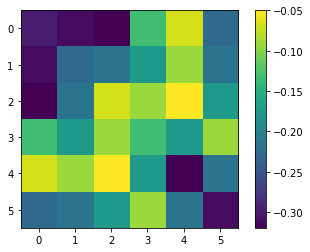

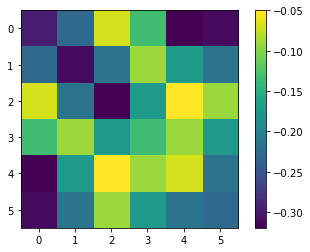

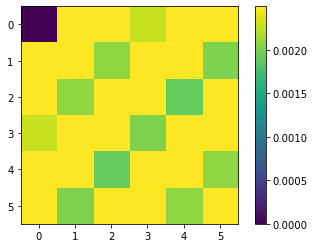

-6.456078751901514

In [32]:
import matplotlib.pyplot as plt
plt.imshow(energies_plus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(energies_minus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(susc_uniform, interpolation='nearest')
plt.colorbar()
plt.show()


np.sum(energies_minus[..., 0].real)

In [27]:
Alat = np.array([[1, 0], [1. / 2., np.sqrt(3) / 2.]])
G = 2 * np.pi * np.array([[1, -1. / np.sqrt(3)], [0, 2 / np.sqrt(3)]])  # is this momentum compatible?

print(Alat.dot(G) /2 / np.pi)

def get_interaction(n_bands, qx, qy, U, J):
    U_total = np.zeros((2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)
    q_phys = (G[0] * qx + G[1] * qy) / L
    exp_q1 = np.exp(1.0j * np.dot(q_phys, Alat[0]))
    exp_q2 = np.exp(1.0j * np.dot(q_phys, Alat[1]))

    
    for band in range(4):
        U_total[band, band, band + 4, band + 4] += -U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band + 4, band, band] += -U
        
    for band in range(4):
        U_total[band + 4, band + 4, band, band] += -U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band, band + 4, band + 4] += -U
    
    for subl in range(2):
        for nu in range(2):
            nubar = 1 - nu
            band = subl * 2 + nu
            bandbar = subl * 2 + nubar
            
            for s in range(2):
                for sbar in range(2):
                    U_total[band + 4 * s, band + 4 * s, bandbar + 4 * sbar, bandbar + 4 * sbar] += -U
                    U_total[bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar, band + 4 * s] += +U
                    U_total[band + 4 * s, bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar] += +U
                    U_total[bandbar + 4 * sbar, bandbar + 4 * sbar, band + 4 * s, band + 4 * s] += -U
    
    AB_factor = (1. + exp_q1 + exp_q2) / 2
    BA_factor = (1. + np.conj(exp_q1) + np.conj(exp_q2)) / 2
    
    for nuA in range(2):
        for nuB in range(2):
            for sA in range(2):
                for sB in range(2):
                    U_total[0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB] = -J * AB_factor
                    U_total[1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA] = +J * AB_factor
                    U_total[0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB] = +J * AB_factor
                    U_total[1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA] = -J * AB_factor
                    
                    U_total[1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB] = -J * BA_factor
                    U_total[0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA] = +J * BA_factor
                    U_total[1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB] = +J * BA_factor
                    U_total[0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA] = -J * BA_factor
    #assert np.allclose(U_total, U_total.transpose((3, 2, 1, 0)).conj())         
    return U_total


U_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
U_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)

chi_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
chi_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


U = 10.
J = 0.0#235 # FIXME: check the sign of this term
for qx in range(Ls):
    for qy in range(Ls):
        inter = get_interaction(n_bands, qx, qy, U, J)
        U_s[qx, qy, ...] = inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]
        U_c[qx, qy, ...] = -inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]

        
        chi_s[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) - susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        chi_c[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) + susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        
        for a in range(4):
            for b in range(4):
                for c in range(4):
                    for d in range(4):
                        if (a + c) % 2 != (b + d) %2:
                            assert np.isclose(chi_c[qx, qy, a, b, c, d], 0.0)
                            assert np.isclose(chi_s[qx, qy, a, b, c, d], 0.0)
        # after interaction account, still converve valley number
green = np.zeros((Ls, Ls, n_bands, n_bands), dtype=np.complex128)

for kx in range(Ls):
    for ky in range(Ls):
        for a in range(n_bands):
            for b in range(n_bands):
                for band in range(n_bands):
                    green[kx, ky, a, b] += A[kx, ky, a, band] * \
                                   np.conj(A[kx, ky, b, band]) / \
                                  (-energies[kx, ky, band].real)
                if (a + b) % 2 == 1:
                    #print(green[kx, ky, a, b])
                    assert np.isclose(green[kx, ky, a, b], 0.)

[[ 1.         -0.57735027]
 [ 0.5         0.71132487]]


In [28]:
Gsinglet = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


for qx in range(Ls):
    for qy in range(Ls):
        Gsinglet[qx, qy, ...] = (3. / 2. * U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ chi_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) + \
                                 U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. + \
                                 U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. - \
                                 0.5 * U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ chi_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        #Gsinglet[qx, qy, ...] = (U_s[qx, qy, ...] + U_c[qx, qy, ...]) / 2.
        
@jit(nopython=True)
def construct_op(Ls, n_bands, Gsinglet, beta, green):
    op = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for qx in range(Ls):
                for qy in range(Ls):
                    for abar in range(n_bands):
                        for bbar in range(n_bands):
                            for cbar in range(n_bands):
                                for dbar in range(n_bands):
                                    for a in range(n_bands):
                                        for b in range(n_bands):
                                            op[kx, ky, qx, qy, abar, bbar, cbar, dbar] -= 1. / Ls ** 2 / beta * \
                                                Gsinglet[(kx - qx) % Ls, (ky - qy) % Ls, a, abar, bbar, b] * \
                                                green[qx, qy, a, cbar] * \
                                                green[(-qx) % Ls, (-qy) % Ls, b, dbar]# FIXME --> need conj?#np.conj(green[(-qx) % Ls, (-qy) % Ls, b, dbar])
    return op


op = construct_op(Ls, n_bands, Gsinglet, beta, green)
#for kx in range(Ls):
#    for ky in range(Ls):
#        assert np.allclose(op[kx, ky, ...], op[0, 0, ...])
op = op.transpose((0, 1, 4, 5, 2, 3, 6, 7)).reshape((Ls ** 2 * n_bands ** 2, Ls ** 2 * n_bands ** 2))

In [29]:
#print(np.unique(op))

from scipy.sparse.linalg import eigsh, eigs

E, eig = np.linalg.eig(op)#eigs(op, k=6, which='LR', maxiter=100000)
#E, eig = eigs(op, k=6, which='LR', maxiter=10000)#, tol=1e-10)
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q


#for e, vec in zip(E, eig.T):
#    assert np.allclose(op.dot(vec), e * vec)
#print(np.sort(-E.real) * -1)
eig = eig[:, np.argsort(-E.real)]
E = E[np.argsort(-E.real)]
print(E.real)

eig = gram_schmidt_columns(eig)

[ 3.26416025e+05  3.26416025e+05  1.16042979e+03  1.16042979e+03
  8.15012434e+02  8.15012434e+02  4.17990872e+02  4.17990872e+02
  4.17990806e+02  4.17990806e+02  3.94638195e+02  3.94638195e+02
  3.94313379e+02  3.94313379e+02  3.57862577e+02  3.57862577e+02
  3.57718447e+02  3.57718447e+02  2.93758727e+02  2.93758727e+02
  2.93758681e+02  2.93758681e+02  2.84319174e+02  2.84319174e+02
  2.84319100e+02  2.84319100e+02  2.74473448e+02  2.74473448e+02
  2.72779011e+02  2.72779011e+02  2.34210007e+02  2.34210007e+02
  2.00676126e+02  2.00676126e+02  1.92058831e+02  1.92058831e+02
  1.91281779e+02  1.91281779e+02  1.32855598e+02  1.32855598e+02
  1.31776950e+02  1.31776950e+02  1.29199795e+02  1.29199795e+02
  1.27836503e+02  1.27836503e+02  1.20072147e+02  1.20072147e+02
  1.19897809e+02  1.19897809e+02  1.19498310e+02  1.19498310e+02
  1.19498268e+02  1.19498268e+02  8.19745932e+01  8.19745932e+01
  8.19745932e+01  8.19745932e+01  5.20560907e+01  5.20560907e+01
  3.94795371e+01  3.94795

1.0


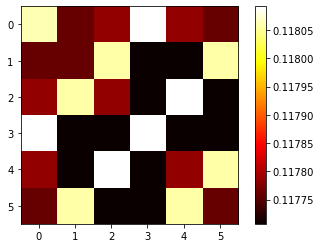

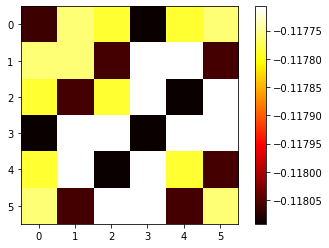

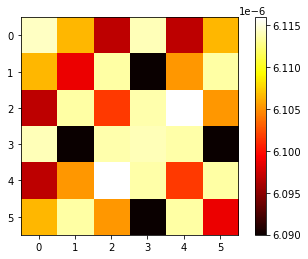

In [30]:
vec = eig[:, 0].reshape((Ls, Ls, n_bands, n_bands))[..., 0, 0].flatten()
import matplotlib.pyplot as plt

maxelem = 1.#vec[np.argmax(np.abs(vec))]
print(maxelem)
plt.imshow(np.abs(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.real(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.imag(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [31]:
vals = []
#mapping = mapping.conj()
gaps_realspace = []
for j in range(E.shape[0]):
    if np.abs(E[j]) < 1e-10:
        continue
    vec = eig[:, j].reshape((Ls ** 2, n_bands, n_bands))
    print(vec[0, ...] * 6 / np.sqrt(2) * 2.)
    gap_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    for i in range(Ls ** 2):
        gap_matrix[i * n_bands:i * n_bands + n_bands, \
                   i * n_bands:i * n_bands + n_bands] = vec[i, ...]
        #print(i, vec[i, ...]);# print(vec[0, ...])
        #assert np.allclose(vec[i, ...], vec[0, ...])

    gap_relspace = fft.dot(gap_matrix).dot(fft.conj().T)
    gaps_realspace.append(gap_relspace * 1.)
    #print(gap_relspace[:4, :4])
    #print(gap_relspace[:4, :4] / (mapping.dot(gap_relspace).dot(mapping.T)[:4, :4] + 1e-10))
    assert np.isclose(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()) * 16, 1.0)
    
    vals.append(np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    print(E[j], np.vdot(gap_relspace.flatten(), mapping.dot(mapping).dot(gap_relspace).dot(mapping.dot(mapping).T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Tx.dot(gap_relspace).dot(Tx.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Ty.dot(gap_relspace).dot(Ty.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    #print(np.sum(np.abs(gap_relspace[:4, :4] - gap_relspace[4:8, 4:8])))
print(sum(vals[:2]), np.exp(2.0j * np.pi / 3.))
#print('----------')
#print(gaps_realspace[0][:4, :4] + gaps_realspace[1][:4, :4])

[[-1.00179411e+00+5.18824538e-05j -7.94216115e-20+7.17344837e-24j
   1.55094850e-04-4.01490092e-09j  3.61427428e-23+2.05492848e-25j]
 [ 9.27372016e-27+1.14213448e-27j  1.10835724e-25+3.72657283e-26j
   1.46140578e-32+4.89743154e-33j  8.86209314e-31+1.58937198e-31j]
 [ 1.55094718e-04-4.01489749e-09j  1.27455914e-38-1.13159927e-38j
  -1.00179411e+00-1.60753635e-08j -8.04531103e-39+6.91479670e-39j]
 [-1.33907598e-38-6.36199197e-40j  4.60111257e-31+1.54793731e-31j
   1.40739631e-38+6.53232291e-39j -7.56951630e-28-2.55077642e-28j]]
(326416.0247817643-3.917089090228985e-12j) (-0.4999999909872886-0.8660253881739668j) (-0.4999999909872891+0.8660253881739652j) (1-2.541098841762901e-21j) (1-8.470329472543003e-22j)
[[ 8.60764372e-15-2.78649414e-15j  0.00000000e+00+4.07428933e-22j
  -8.91962887e-17+4.44086600e-17j -1.50208388e-22+3.84972956e-21j]
 [ 1.62884857e-21-2.89204351e-21j -1.00179411e+00-5.18824538e-05j
  -2.14020261e-21-8.44443842e-22j  1.55094718e-04+4.01489749e-09j]
 [-8.96092426e-17+3.

(272.77901094790684-2.9132252166164108e-12j) (0.220743294058326+0.3425251344730512j) (0.22074329405832666-0.3425251344730509j) (1-8.673617379884035e-19j) (1-2.6020852139652106e-18j)
[[ 2.79216382e-12-2.21448171e-12j  2.87046902e-16+3.67990420e-18j
   1.75704222e-13-1.31387895e-13j -2.05154659e-16+1.76635402e-16j]
 [ 1.14537018e-16-5.88784672e-17j  8.41757521e-13+1.93076997e-13j
   1.93194971e-17+2.94392336e-17j -1.57727120e-13+6.15093136e-14j]
 [ 5.88857790e-14-1.02676615e-13j  3.12791857e-17+5.88784672e-17j
  -3.61985576e-13-2.92262102e-15j  1.83995210e-17-4.81262471e-17j]
 [-1.40296348e-16+3.21991618e-17j  2.39220945e-14+2.64177034e-14j
  -6.27883654e-17+2.94392336e-17j -1.11606941e-12-5.92604783e-13j]]
(272.7790109478974+1.2603564025770453e-12j) (0.22074329405857007-0.3425251344728279j) (0.22074329405857068+0.3425251344728279j) (1.0000000000000002-1.3877787807814463e-17j) (1.0000000000000002-2.0816681711721694e-17j)
[[-5.06358789e-01+1.22474431e+00j -5.66897750e-17+5.20619941e-17j
 

(39.47953712701848+1.2848188490472738e-11j) (-0.47386059704788475+0.7696999951696946j) (-0.4738605970478863-0.7696999951696937j) (1+3.469446951953618e-17j) (0.9999999999999999-3.469446951953618e-17j)
[[-3.41925152e-08-2.45350631e-07j -2.21047245e-15-4.05709438e-16j
   1.83709189e-07+7.38728215e-07j  7.23791158e-16-8.83177000e-17j]
 [-4.48948311e-16-1.43516262e-16j  9.40066691e-09+3.04790810e-07j
   6.20063863e-16-2.18954293e-16j  4.10366312e-08-5.48942948e-07j]
 [ 1.07911007e-07+4.33930781e-07j -3.98349629e-16+1.50876072e-16j
  -8.47886009e-08-2.32755015e-07j -1.00277393e-16+3.65230494e-16j]
 [ 2.94392346e-17-2.75072838e-16j  6.98582183e-08-9.34516923e-07j
   6.28746122e-17+2.98072240e-16j -5.46235464e-08+3.00007131e-07j]]
(37.407441606344+3.8710368237962376e-11j) (-0.4761826208509296+0.16902597281540518j) (-0.4761826208509305-0.1690259728154057j) (0.9999999999999998+1.387778780781445e-17j) (1-8.673617379884032e-18j)
[[ 8.56524932e-09+3.04810676e-07j -2.62265047e-15-8.16938732e-16j
  -

(15.02577181927059+1.1757261830780408e-13j) (0.2042173704267128+0.08558705295802305j) (0.20421737042671334-0.08558705295802321j) (1-4.163336342344341e-17j) (1-2.0816681711721704e-17j)
[[ 6.21552798e-11+2.61492470e-11j  7.90776913e-16-1.19136898e-16j
  -2.75667651e-12+7.91272629e-12j -2.29994013e-17+5.15186588e-17j]
 [ 3.70980342e-16+1.52716024e-16j  1.23756865e-11+1.36734219e-12j
   2.23370185e-15+3.86389941e-17j  1.49854877e-11-1.57778634e-11j]
 [-5.77885596e-12+9.11811448e-12j -2.40113749e-16+1.47196168e-17j
  -1.79197202e-11+3.25433213e-11j -1.51060067e-15-1.05337258e-15j]
 [-5.32091148e-16-9.49702776e-16j  1.37555228e-11-1.52022522e-11j
   3.02672120e-16+2.81512671e-16j  8.80556763e-12-3.54820699e-12j]]
(15.025770310637457-3.667288694941817e-12j) (0.20421773843642466-0.08130782010269441j) (0.2042177384364253+0.08130782010269402j) (1-2.4286128663675293e-17j) (0.9999999999999998-5.20417042793042e-17j)
[[ 1.31424062e-10-2.01837352e-10j  9.12616242e-16+9.58097558e-16j
   4.01164265e-12

(7.773543387124319+6.3249720230886124e-12j) (-0.07436655981983711+0.12879145664101474j) (-0.07436655981983734-0.12879145664101463j) (1+1.0842021724855056e-19j) (0.9999999999999999-2.710505431213764e-20j)
[[-1.49313160e-01+4.18556264e-02j  9.57027960e-15+1.13950569e-15j
  -4.06964320e-01+1.14893776e-01j -9.48715574e-16+2.46223742e-16j]
 [ 5.51768578e-16-1.03934085e-15j  3.81269337e-01-7.05895602e-04j
   4.71774671e-15+1.91790611e-15j  1.03972158e+00+8.34717962e-11j]
 [-4.06964313e-01+1.14893774e-01j -2.08846413e-15+2.10283733e-16j
  -1.49157152e-01+4.24082252e-02j -2.44339634e-15+9.09856512e-16j]
 [ 3.53086718e-15-1.22033721e-15j  1.03972160e+00+8.66683070e-11j
   1.69777609e-15-3.12597392e-17j  3.81269337e-01+7.05895820e-04j]]
(6.555534808204038+8.32801314969133e-12j) (-0.44531191302300877+0.5523470820443133j) (-0.4453119130230092-0.5523470820443125j) (1+5.204170427930423e-18j) (1+6.93889390390723e-18j)
[[ 3.79817290e-01+3.32509578e-02j -2.18184651e-14-8.21797328e-15j
   1.03592621e+00

(-3.8591023242918445+3.428170458863321e-13j) (0.24846480854955455-0.3845523105511782j) (0.24846480854955505+0.38455231055117783j) (1-8.673617379884049e-19j) (1-6.938893903907239e-18j)
[[ 2.93232546e-10-4.24871802e-10j -8.49567483e-08+3.69474090e-07j
  -1.63288790e-11+2.08306866e-11j  1.06011997e-07-1.82631183e-08j]
 [ 5.91556569e-08-4.59842599e-08j -1.28650061e-10+4.32864890e-11j
   8.48258612e-08-6.05025316e-08j -1.63033724e-11+3.27664183e-12j]
 [ 2.14558864e-12-6.30749949e-12j  7.31871972e-09-4.11247525e-08j
  -2.86716589e-10+4.19658172e-10j -4.36990626e-08-8.61579783e-10j]
 [-3.17008622e-08+3.72586765e-08j -1.32299794e-11+8.64774621e-12j
  -3.48676316e-08+6.77057782e-09j  1.32768580e-10-5.01400863e-11j]]
(-3.859102324314745-7.715668169346522e-12j) (0.24846480864910264+0.3845523104105265j) (0.24846480864910295-0.38455231041052645j) (1+6.938893903907255e-18j) (1+1.2143064331837696e-17j)
[[-1.28124879e-10-2.09432736e-10j -5.10430649e-08+3.45410377e-07j
   2.96440910e-11+8.25808919e-12j

(-8.233605841270942-1.241945999166938e-13j) (-0.4999999999998428+0.8655282694836647j) (-0.49999999999984457-0.8655282694836642j) (0.9999999999999998+6.776263578034397e-21j) (1-2.032879073410319e-20j)
[[-7.63814685e-12-1.98306853e-12j -7.83282582e-08+1.13415907e-08j
   2.55750201e-10-6.80819268e-12j  7.17946315e-08+1.52306266e-08j]
 [-8.19417994e-08-3.36738541e-09j -3.35107728e-13+3.42740054e-13j
  -1.63783531e-08+6.24046652e-09j -2.61599118e-11-1.83643030e-11j]
 [-1.72134130e-10+3.23952095e-11j -4.54801158e-09+1.09561629e-09j
  -8.55905741e-12-1.74342875e-12j -8.41643803e-09-4.31415363e-09j]
 [-6.26553503e-09+9.50403846e-10j  2.22280638e-11+1.40108361e-11j
   4.82314634e-09-5.38480321e-09j  5.14950062e-13+8.61134744e-13j]]
(-8.233605841272214-7.893685705084863e-14j) (-0.4999999999997755-0.8655282694834553j) (-0.49999999999977623+0.865528269483454j) (1-5.421010862427551e-20j) (1+1.3552527156068878e-20j)
[[ 8.92845956e-13-2.09843593e-12j  1.22433609e-07-6.88532560e-08j
   7.64664234e-12+

(-18.066281983754386-1.172215622498072e-11j) (0.12809581004288012+0.009918387668871405j) (0.1280958100428804-0.009918387668871449j) (1.0000000000000002+1.647987302177967e-17j) (1+0j)
[[-2.04051148e-13-5.02905828e-13j  3.44024078e-08-8.21445614e-09j
   3.41477286e-13-1.47049678e-11j -9.12814222e-09+5.06572983e-09j]
 [-3.67692500e-09-1.13568520e-08j -9.30123637e-14+4.75030548e-13j
  -2.10880491e-08-3.12611984e-09j  3.71818667e-12+6.42139905e-12j]
 [ 1.63606831e-11-1.84755212e-14j -1.66208223e-09+9.07864962e-10j
  -5.08946988e-13-1.25526948e-12j  3.44862917e-08+6.86457716e-09j]
 [-4.22394955e-08-6.41479638e-08j  1.34500400e-13-1.22050005e-11j
   1.15725069e-09-1.57700292e-09j -3.45621435e-13+3.78139725e-13j]]
(-18.066281983765556-5.075551315626603e-12j) (0.12809581003612497-0.009918387648628473j) (0.1280958100361253+0.009918387648628535j) (1-1.170938346284346e-17j) (1-7.372574772901438e-18j)
[[-1.25102023e-13-7.20237290e-13j -4.76146762e-09+4.18684810e-10j
  -2.05109921e-13-3.78546703e-12

(-60.982358159989815+1.6391918204738953e-12j) (-0.49710314470253414-0.09327737471912198j) (-0.497103144702535+0.09327737471912224j) (1-1.2143064331837656e-17j) (1+1.0408340855860847e-17j)
[[-1.33519059e-08+1.03522403e-08j  1.97198900e-08+1.59037761e-08j
   6.92905888e-08-6.13513695e-08j -4.74380360e-09-7.01982836e-09j]
 [-7.82733041e-11-1.47975404e-09j -1.21638618e-08-1.43822270e-08j
   2.10285648e-09+1.48933206e-09j -8.45631737e-08-1.14315829e-07j]
 [-9.54930968e-08+8.45405283e-08j  7.30376804e-10+1.24211350e-09j
  -1.18942291e-08+1.19986843e-08j -1.42569497e-09+1.29404992e-09j]
 [ 2.41010060e-09-1.97060846e-08j  6.13566309e-08+8.29512407e-08j
   2.03677216e-09+2.20444953e-09j -1.01928433e-08-1.58402835e-08j]]
(-60.982358159998235+1.0231815394945443e-11j) (-0.49710314470255157+0.09327737471927591j) (-0.4971031447025525-0.09327737471927587j) (1.0000000000000002-4.85722573273506e-17j) (1.0000000000000004+2.0816681711721685e-17j)
[[ 1.00775020e-14-1.75610913e-13j  9.81622401e-12+3.294422

(-507.4915165631749+7.086498055031143e-12j) (0.19674089539848438-0.09163980217432169j) (0.19674089539848474+0.09163980217432181j) (1+1.387778780781446e-17j) (1+0j)
[[-2.17114348e-16-3.09169451e-16j -1.01478023e-11+6.19140016e-11j
  -5.47541629e-15-8.38958716e-15j -2.96969383e-11-2.74561164e-11j]
 [ 8.70322131e-11+1.20249377e-10j  1.19664668e-15+3.44175245e-15j
  -8.03310366e-11-1.58905047e-11j  8.92384524e-15-9.73381841e-14j]
 [-3.44050495e-14+1.00766121e-14j  4.14807097e-11-6.66427701e-11j
  -2.47940249e-17+2.23185235e-16j  4.33814816e-10-3.17896926e-10j]
 [ 2.06451008e-09+5.58550341e-10j  1.75763696e-13-4.38418232e-13j
   1.01926755e-11-1.66919097e-11j -1.70663709e-16+1.40575806e-15j]]
(-507.49166977289093+3.187786840053164e-12j) (0.19674048246816422-0.34009291759778715j) (0.19674048246816472+0.3400929175977867j) (1-6.938893903907228e-17j) (1-2.7755575615628914e-17j)
[[-1.86795028e-15-8.37273437e-15j -1.71525376e-10-3.16481686e-10j
   5.52539946e-13+1.82360463e-13j  2.30497539e-10+3.

In [23]:
green = green.reshape((Ls ** 2, n_bands, n_bands))

green_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)

for i in range(Ls ** 2):
    green_matrix[i * n_bands:i * n_bands + n_bands, \
                 i * n_bands:i * n_bands + n_bands] = green[i, ...]

green_relspace = fft.dot(green_matrix).dot(fft.conj().T)
print(np.dot(green_relspace.conj().flatten(), mapping.dot(green_relspace).dot(mapping.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Tx.dot(green_relspace).dot(Tx.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Ty.dot(green_relspace).dot(Ty.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))

(1.0000000000000007+2.218334208300264e-18j)
(1.0000000000000002-1.373840597090161e-18j)
(1+1.1193719171028809e-18j)


In [ ]:
print(np.sum(np.abs(gap_relspace[:4, 8:12] - gap_relspace[4:8, 12:16])))
print(np.dot(gap_relspace.conj().flatten(), gap_relspace.dot(mapping).flatten()))

In [ ]:
Alat[1] @ G[0] / 2 / np.pi